<a href="https://colab.research.google.com/github/KCachel/fairranktune/blob/main/examples/07_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# FairRankTune Demonstration


# FairRankTune Demonstration
In this notebook, you'll find a demonstration of some of the capabilities of the FairRankTune library.

## What is Fairness in FairRankTune?
There are many ways in which a ranking can be unfair. [FairRankTune](https://kcachel.github.io/fairranktune/) aims to help you diagnose and solve issues related to group fairness and individual fairness. When it comes to groups there are different kinds of group fairness issues:


*   Fairness that considers scores associated with items. For instance, you might want groups to receive favorable positions proportional to their scores. An example such metric is [exposure utility](https://kcachel.github.io/fairranktune/metrics/#exposure-utility-expu).
*   Fairness that only considers the relative ordering of items. Your ranking could be putting all the members of a certain group at the top compared to other. An example meteric that assess this is [NDKL](https://kcachel.github.io/fairranktune/metrics/#normalized-discounted-kl-divergence-ndkl).

## What does this Notebook Demonstrate?
Imagine you work on a team at your company that has been developing a new proprietary ranking algorithm `rankify`. You want to use `rankify` to prioritize how job applicants are shown to hiring teams, so you want to make sure it's not advantaging certain groups, specifically males over females. Using historical data, you'd like to understand how this algorithm impacts different groups compared to the company's old ranking process. You'd also like to see how it compares to methods that already exist for making fair rankings.

We will:

*   Fairness test `rankify` compared to the company's old approach `old` on historical data
*   Fairness test `rankify` compared to the company's old approach `old` on a Hypothetical Unfair Scenario
*   Compare `rankify` to an existing fair ranking algorithm



### Part 0: Preparation
We are going to import FairRankTune, load in our historical data, implement `old`, and  implement `rankify`.

For simplicity we are going to assume the German Credit data is our historical data, `old` sorts candidates by descending scores, and `rankify` is a quick routine that adds the average men's score to every women's score.

In [2]:
!pip install FairRankTune

In [3]:
import FairRankTune as frt
import numpy as np
import pandas as pd
from FairRankTune import RankTune, Metrics, Rankers
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

#Load Historical Dataset
german_credit = pd.read_csv('https://raw.githubusercontent.com/KCachel/fairranktune/main/examples/data/german_credit.csv')
german_credit = german_credit.assign(candnumber = list(range(0, len(german_credit))))
german_credit = german_credit.assign(Sex = german_credit['Sex & Marital Status'].map({ 1 :'Male', 2:'Male',3:'Male',4:'Female' })) #Map group values
score = 'Credit Amount'
groups = 'Sex'
german_credit = german_credit[['candnumber', groups, score]]


def old_rank(df_data, score_col):
  return df_data.copy(deep=True).sort_values(score_col, ascending=False) #Sort the candidate by the score column

def rankify(df_data, score_col, group_col, add_group):
  new = df_data.copy(deep=True)
  avg2add2F = new.loc[new[group_col] == add_group, score_col].mean()
  new.loc[new[group_col] != add_group, score_col] = new.loc[new[group_col] != add_group, score_col] + avg2add2F
  return new.sort_values(score_col, ascending=False) #Sort the candidate by the new score

### Part 1: Fairness Test `rankify` on Historic Data
We are going to test `rankify` using two types of group fairness. Score-based group fairness, and statistical parity. For statistical parity we will use [group exposure (EXP)](https://kcachel.github.io/fairranktune/metrics/#group-exposure-exp) and for score-based fairness we will use [group exposure utility (EXPU)](https://kcachel.github.io/fairranktune/metrics/#exposure-utility-expu).

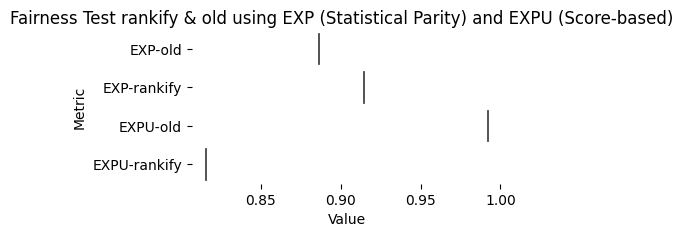

In [4]:
#Generate rankings
old_ranking = old_rank(german_credit, score)
rankify_ranking = rankify(german_credit, score, groups, 'Male')
item_group_dictionary = dict(zip(german_credit['candnumber'].to_list(), german_credit[groups].to_list())) #Make item_group dict

#Normalize the credit amounts
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
old_ranking[[score]] = pd.DataFrame(min_max_scaler.fit_transform(old_ranking[[score]].values))
rankify_ranking[[score]] = pd.DataFrame(min_max_scaler.fit_transform(rankify_ranking[[score]].values))

#Calculate metrics using MinMaxRatio
EXP_minmax_old, avg_exposures_old = frt.Metrics.EXP(old_ranking[['candnumber']],
                                                    item_group_dictionary, 'MinMaxRatio')
EXP_minmax_rankify, avg_exposures_rankify = frt.Metrics.EXP(rankify_ranking[['candnumber']],
                                                            item_group_dictionary, 'MinMaxRatio')
EXPU_minmax_old, per_group_old = frt.Metrics.EXPU(old_ranking[['candnumber']], item_group_dictionary,
                                                  old_ranking[[score]], 'MinMaxRatio')
EXPU_minmax_rankify, per_group_rankify = frt.Metrics.EXPU(rankify_ranking[['candnumber']],
                                                          item_group_dictionary, rankify_ranking[[score]], 'MinMaxRatio')

#For plotting
metric_data = [['EXP-old', EXP_minmax_old], ['EXP-rankify', EXP_minmax_rankify],
        ['EXPU-old', EXPU_minmax_old], ['EXPU-rankify', EXPU_minmax_rankify]]
# Create the pandas DataFrame
metric_df = pd.DataFrame(metric_data, columns=['Metric', 'Value'])
figsize = (4, .5 * len(metric_df['Metric'].unique()))
plt.figure(figsize=figsize)
plt.suptitle('Fairness Test rankify & old using EXP (Statistical Parity) and EXPU (Score-based)')
sns.violinplot(metric_df, x='Value', y='Metric', hue='Metric', inner='point')
sns.despine(top=True, right=True, bottom=True, left=True)


Remember that using MaxMinRatio to measure unfairness means that So on historical data we can see, in terms of [group exposure (EXP)](https://kcachel.github.io/fairranktune/metrics/#group-exposure-exp) that `old` was pretty fair to begin with and `rankify` improves the EXP. Then we see in terms of [(EXPU)](https://kcachel.github.io/fairranktune/metrics/#exposure-utility-expu) old was very fair, and `rankify` actually makes it less fair. So depending on our fairness objecitve `rankify` can help or hurt.

 ## Part 2: Fairness Test rankify on a Hypothetical Scenario
Since `rankify` is just trying to lift up females, we would also like to focus our efforts on group exposure (EXP), instead of the score-based fairness  group exposure utility (EXPU). But the problem is our historical data didn't actually show that many disparities between females and males, we would like to test our algorithms on data that exhibits more bias.

To do that we will use the RankTune data generator to make a dataset that has the exact same distribution of groups as our historical data, but with more bias. We will use the score generation functionality of [RankTune](https://kcachel.github.io/fairranktune/ranktune/#using-an-existing-dataset).

Then we will still test rankify using group exposure (EXP). We will measure it in two different ways with MaxMinRatio and with MaxMinDiff.


*Measuring with MaxMinRatio:*



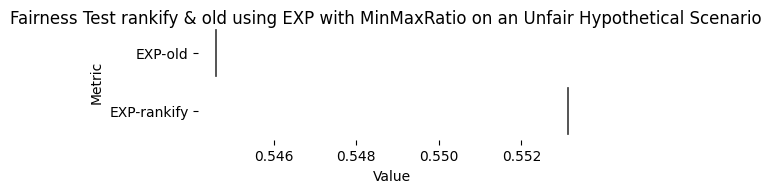

In [5]:
#Generate data using the same distribution of groups as our historical data,
# but with significant bias
phi = 0.1 #Generate a biased ranking
r_cnt = 1 #Generate 1 ranking
seed = 10 #For reproducibility
ranking_df, item_group_dict, score_df = frt.RankTune.ScoredGenFromItems(item_group_dictionary,
    phi, r_cnt, 'uniform', seed)

german_credit_syn =  pd.concat([ranking_df, score_df], ignore_index=True, sort = False, axis = 1)
german_credit_syn[groups] = list(item_group_dict.values())[::-1]
german_credit_syn.columns = ['candnumber', 'Credit Amount', groups]

#Generate rankings
old_ranking = old_rank(german_credit_syn, score)
rankify_ranking = rankify(german_credit_syn, score, groups, 'Female')
item_group_dictionary = item_group_dict #Make item_group dict


#Calculate metrics using MinMaxRatio
EXP_minmax_old_hs, avg_exposures_old = frt.Metrics.EXP(old_ranking[['candnumber']], item_group_dictionary, 'MinMaxRatio')
EXP_minmax_rankify_hs, avg_exposures_rankify = frt.Metrics.EXP(rankify_ranking[['candnumber']], item_group_dictionary, 'MinMaxRatio')

#For plotting
metric_data = [['EXP-old', EXP_minmax_old_hs], ['EXP-rankify', EXP_minmax_rankify_hs]]
# Create the pandas DataFrame
metric_df = pd.DataFrame(metric_data, columns=['Metric', 'Value'])
figsize = (5, .75 * len(metric_df['Metric'].unique()))
plt.figure(figsize=figsize)
plt.suptitle('Fairness Test rankify & old using EXP with MinMaxRatio on an Unfair Hypothetical Scenario')
sns.violinplot(metric_df, x='Value', y='Metric', hue='Metric', inner='point')
sns.despine(top=True, right=True, bottom=True, left=True)

Looking at `old` really shows us how the generated data is unfair. But we can also see that `rankify` really helps to fix this issue.

Lets repeat this fairness analysis with MaxMinDiff.

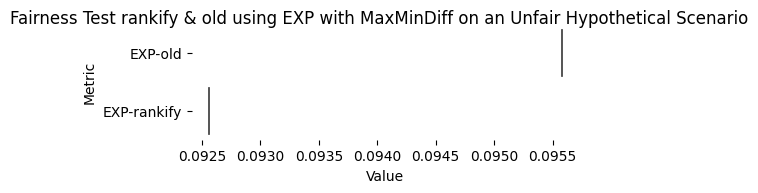

In [6]:
#Calculate metrics using MaxMinDiff
EXP_maxmindiff_old, avg_exposures_old = frt.Metrics.EXP(old_ranking[['candnumber']], item_group_dictionary, 'MaxMinDiff')
EXP_maxmindiff_rankify, avg_exposures_rankify = frt.Metrics.EXP(rankify_ranking[['candnumber']], item_group_dictionary, 'MaxMinDiff')

#For plotting
metric_data = [['EXP-old', EXP_maxmindiff_old], ['EXP-rankify', EXP_maxmindiff_rankify]]
# Create the pandas DataFrame
metric_df = pd.DataFrame(metric_data, columns=['Metric', 'Value'])
figsize = (5, .75 *len(metric_df['Metric'].unique()))
plt.figure(figsize=figsize)
plt.suptitle('Fairness Test rankify & old using EXP with MaxMinDiff on an Unfair Hypothetical Scenario')
sns.violinplot(metric_df, x='Value', y='Metric', hue='Metric', inner='point')
sns.despine(top=True, right=True, bottom=True, left=True)

Since we are using `MaxMinDiff` fairer is closer to 0, and unfair is closer to 1. So we can confirm using this different formulation of [group exposure (EXP)](https://kcachel.github.io/fairranktune/metrics/#group-exposure-exp) that our synthetic data was very biased, and so the `old` method that just ranks by decreasing score is completely unfair. So, in this case `rankify` really helps over our old approach.


## Part 3: Compare rankify to an existing fair ranking algorithm.

We would like to know how our new algorithm `rankify` compares to an existing fair ranking algorithm. Lets do this by comparing its performance to [DetConstSort ](https://kcachel.github.io/fairranktune/rankers/#detconstsort-re-ranker) on both datasets.




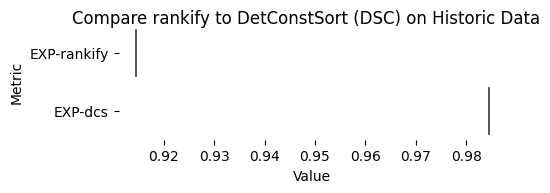

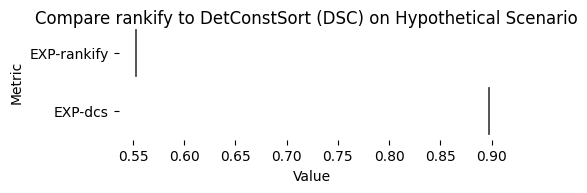

In [7]:
# Need to run DetConstSort on both datasets
# Historical data
_, cnts = np.unique(german_credit['Sex'].tolist(), return_counts = True)
proportions = cnts/sum(cnts)
distribution= dict(zip([0, 1], [proportions[0], proportions[1]])) #Females 1, Males 1
ranking = pd.DataFrame(german_credit['candnumber'].to_list())
scr = pd.DataFrame(german_credit[score].to_list())
k = sum(cnts)
grp_key = dict(zip(['Female', 'Male'], [0,1]))
int_grp_dict =  {key: grp_key[value] for key, value in item_group_dictionary.items()}

#Apply DetConstSort Algorithm
hist_dcs_df, item_group_d, hist_dcs_scores = frt.Rankers.DETCONSTSORT(ranking, int_grp_dict,
                                                                        scr, distribution, k)

#Hypothetical scenario
int_grp_dict_hs =  {key: grp_key[value] for key, value in item_group_dict.items()}
hs_dcs_df, item_group_d_hs, hs_dcs_scores = frt.Rankers.DETCONSTSORT(ranking_df, int_grp_dict_hs,
                                                                        score_df, distribution, k)

#Calculate metrics using MinMaxRatio
EXP_hist_dcs, avg_exposures_dcs_hist = frt.Metrics.EXP(hist_dcs_df, item_group_d, 'MinMaxRatio')
EXP_hs_dcs, avg_exposures_dcs_hs = frt.Metrics.EXP(hs_dcs_df, item_group_d_hs, 'MinMaxRatio')



#For plotting
metric_data = [['EXP-rankify', EXP_minmax_rankify], ['EXP-dcs', EXP_hist_dcs]]
# Create the pandas DataFrame
metric_df = pd.DataFrame(metric_data, columns=['Metric', 'Value'])
figsize = (5, .75 * len(metric_df['Metric'].unique()))
plt.figure(figsize=figsize)
plt.suptitle('Compare rankify to DetConstSort (DSC) on Historic Data')
sns.violinplot(metric_df, x='Value', y='Metric', hue='Metric', inner='point')
sns.despine(top=True, right=True, bottom=True, left=True)

#For plotting
metric_data = [['EXP-rankify', EXP_minmax_rankify_hs], ['EXP-dcs', EXP_hs_dcs]]
# Create the pandas DataFrame
metric_df = pd.DataFrame(metric_data, columns=['Metric', 'Value'])
figsize = (5, .75 * len(metric_df['Metric'].unique()))
plt.figure(figsize=figsize)
plt.suptitle('Compare rankify to DetConstSort (DSC) on Hypothetical Scenario')
sns.violinplot(metric_df, x='Value', y='Metric', hue='Metric', inner='point')
sns.despine(top=True, right=True, bottom=True, left=True)

We can see that in both the historic data and our new unfair hypothetical data DCS performs significantly more bias-mitigation than `rankify`.